Prepare observations: convolution, clip, interpolation

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import matplotlib as mpl
import pickle

import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader

from spender import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange

from sbi import utils as Ut
from sbi import inference as Inference

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)

In [2]:
import os

files= sorted(os.listdir('obs'))[1:]
print(files)
waves=[]
fluxes=[]
sigma_gal=[]
for f in files:
    data=np.loadtxt('./obs/'+f)
    waves.append(data[:,0])
    fluxes.append(data[:,1])
    arr=np.array([float(f[6:12]),float(f[13:19])])
    sigma_gal.append(np.mean(arr))

['stack_100.00_110.00_skyup.dat', 'stack_110.00_120.00_skyup.dat', 'stack_120.00_130.00_skyup.dat', 'stack_130.00_140.00_skyup.dat', 'stack_140.00_150.00_skyup.dat', 'stack_150.00_160.00_skyup.dat', 'stack_160.00_170.00_skyup.dat', 'stack_170.00_180.00_skyup.dat', 'stack_180.00_190.00_skyup.dat', 'stack_190.00_200.00_skyup.dat', 'stack_200.00_210.00_skyup.dat', 'stack_210.00_220.00_skyup.dat', 'stack_220.00_230.00_skyup.dat', 'stack_230.00_240.00_skyup.dat', 'stack_240.00_250.00_skyup.dat', 'stack_250.00_260.00_skyup.dat', 'stack_260.00_280.00_skyup.dat', 'stack_280.00_320.00_skyup.dat']


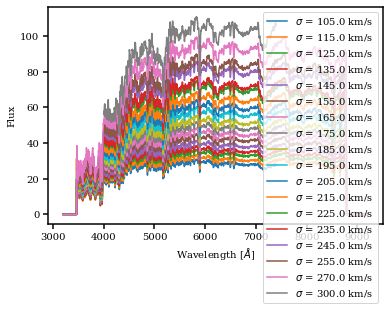

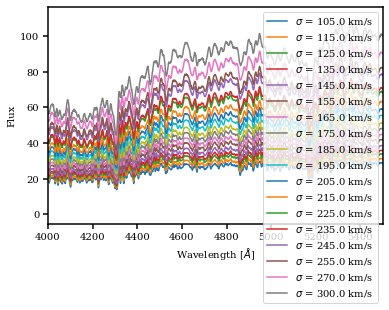

In [3]:
n=len(fluxes)

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend(fontsize=10)
plt.show()


"""for i in range(n):
    print(np.min(waves[i]),np.max(waves[i]))"""

#largest wavelength range from 4000 to 7400 but we will limit ourselves to the range from 4000 to 5500"

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.xlim(4000,5500)
plt.legend(fontsize=10)
plt.show()


In [4]:
fluxes_short=[]
waves_short=[]

for i in range(n):
    ind=np.where((waves[i]>3999)&(waves[i]<7401))[0]
    fluxes_short.append(fluxes[i][ind])
    waves_short.append(waves[i][ind])

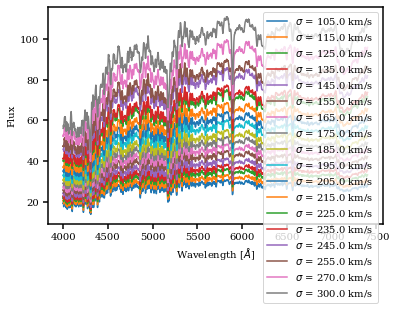

In [ ]:
for i in range(n):
    plt.plot(waves_short[i],fluxes_short[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')

plt.legend(fontsize=10)
plt.show()

In [5]:
def gaussian_filter1d(spec, sig):
    """
    Convolve a spectrum by a Gaussian with different sigma for every pixel.
    If all sigma are the same this routine produces the same output as
    scipy.ndimage.gaussian_filter1d, except for the border treatment.
    Here the first/last p pixels are filled with zeros.
    When creating  template library for SDSS data, this implementation
    is 60x faster than a naive for loop over pixels.
    :param spec: vector with the spectrum to convolve
    :param sig: vector of sigma values (in pixels) for every pixel
    :return: spec convolved with a Gaussian with dispersion sig
    """
    sig = sig.clip(0.01)  # forces zero sigmas to have 0.01 pixels
    p = int(np.ceil(np.max(3*sig)))
    m = 2*p + 1  # kernel size
    x2 = np.linspace(-p, p, m)**2
    n = spec.size
    a = np.zeros((m, n))
    for j in range(m):   # Loop over the small size of the kernel
        a[j, p:-p] = spec[j:n-m+j+1]
    gau = np.exp(-x2[:, None]/(2*sig**2))
    gau /= np.sum(gau, 0)[None, :]  # Normalize kernel
    conv_spectrum = np.sum(a*gau, 0)
    return conv_spectrum

$$ \sigma_{gal}^2=\sigma_{v}^2+\sigma_{ins}^2$$

We are going to convert all of them to $v=300$ km/s, so:

$$ \sigma_{diff}^2 = \sigma_{300}^2+\sigma_{ins}^2 - (\sigma_{gal}^2+\sigma_{ins}^2) = \sigma_{300}^2 - \sigma_{gal}^2   $$

And to move from velocity dispersion to kernel width, we will need:

$$
\mathrm{FWHM}=2 \sqrt{2 \ln 2} \sigma \approx 2.35482 \sigma
$$

In [6]:
cvel=300000 #km/s

"""for i in range(n):
    print(waves_short[i],waves_short[i][1]-waves_short[i][0]) #psize=1 A
"""
psize=1
fluxes_conv=[]
max_sigma=np.sqrt(300**2 - np.array(sigma_gal)**2) #velocity dispersion

for i in trange(n):
    FWHM_gal = 2.*np.sqrt(2.*np.log(2.)) * max_sigma[i] / cvel * waves_short[i]
    FWHM_dif = np.sqrt(FWHM_gal**2)
    sigma = FWHM_dif/(psize*2.*np.sqrt(2.*np.log(2.))) # Sigma difference in pixels, for the kernel
    flux_conv = gaussian_filter1d(fluxes_short[i], sigma) 
    fluxes_conv.append(flux_conv)

100%|██████████| 18/18 [00:00<00:00, 182.55it/s]


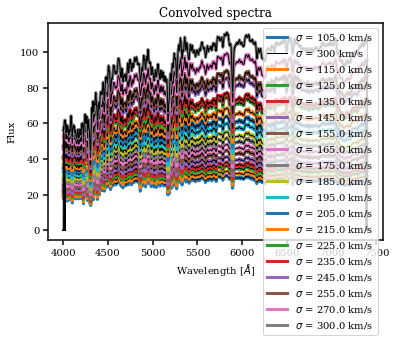

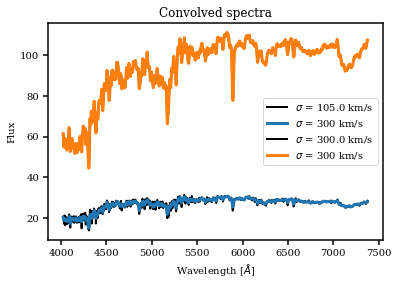

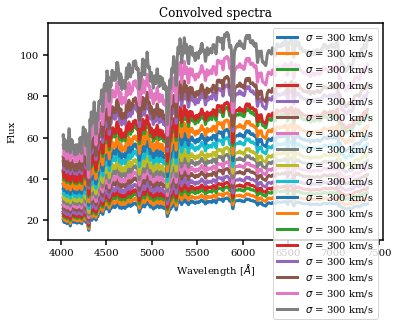

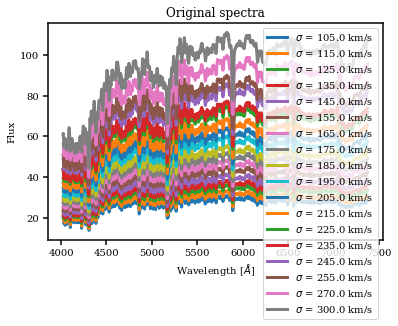

In [7]:
for i in range(n): 
    plt.plot(waves_short[i],fluxes_short[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',lw=3)
    if i==0:
        plt.plot(waves_short[i],fluxes_conv[i],label='$\\sigma$ = '+str(300)+' km/s',c='k',lw=1)
    else:
        plt.plot(waves_short[i],fluxes_conv[i],c='k',lw=1)

plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


for i in [0,-1]:
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',c='k',lw=2)
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


for i in range(n):
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()

for i in range(n):
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Original spectra')
plt.legend(fontsize=10)
plt.show()

In [8]:
#print(fluxes_conv[0][:20])
#print(waves_short[0][:20])
#print(fluxes_conv[0][-30:])
#print(waves_short[0][-30:])

print('First index non zero: ',np.where(fluxes_conv[0]>0)[0][0])
print('Last index non zero: ',np.where(fluxes_conv[0]>0)[0][-1])

print('First index non zero: ',np.where(fluxes_conv[-1]>0)[0][0])
print('Last index non zero: ',np.where(fluxes_conv[-1]>0)[0][-1])


print('Valid wavelength range: ', np.min(waves_short[0][23:3378]),np.max(waves_short[0][23:3378]))

waves_short_2 = []
fluxes_conv_2 = []

print('Selected wavelength range: ',waves_short[0][23],waves_short[0][2000])

for i in range(n):
    waves_short_2.append(waves_short[i][23:2001])
    fluxes_conv_2.append(fluxes_conv[i][23:2001])

First index non zero:  21
Last index non zero:  3379
First index non zero:  1
Last index non zero:  3399
Valid wavelength range:  4023.0 7377.0
Selected wavelength range:  4023.0 6000.0


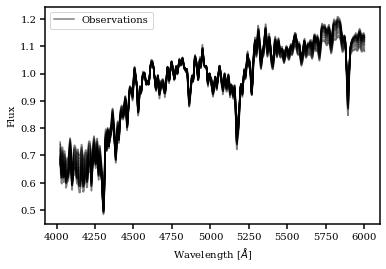

In [9]:

#observations
for i in range(n):
    if i==0:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',label='Observations',alpha=0.5)
    else:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',alpha=0.5)
        
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

#observations are really old galaxies as we see

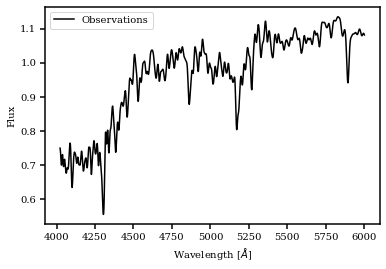

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


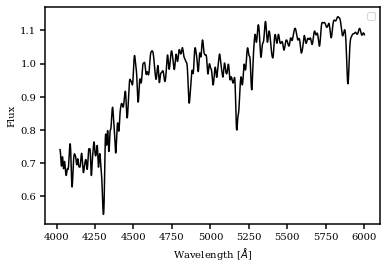

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


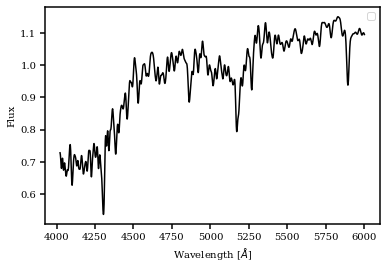

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


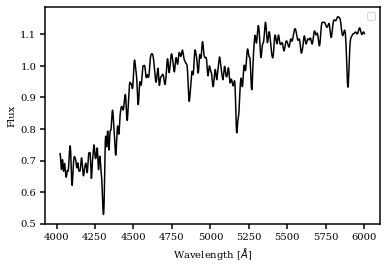

In [16]:
#single observation each time


    
#observations
for i in range(4):

    if i==0:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k',label='Observations')
    else:
        plt.plot(waves_short_2[i],fluxes_conv_2[i]/np.median(fluxes_conv_2[i]),'k')
        
    plt.ylabel('Flux')
    plt.xlabel('Wavelength [$\\AA$]')
    plt.legend()
    plt.show()

#observations are really old galaxies as we see

In [11]:
print(waves_short_2[0])
print(waves_short_2[-1])

#delta lambda MILES = 0.9 A
#delta lambda Observations = 1 A
#Interpolamos para pasar MILES a 1 Amstrong



[4023. 4024. 4025. ... 5998. 5999. 6000.]
[4023. 4024. 4025. ... 5998. 5999. 6000.]


In [14]:
#SAVE


seds=[]
for i in range(18):
    seds.append(fluxes_conv_2[i]/np.median(fluxes_conv_2[i]))

np.save('./obs/processed/seds.npy',seds)
np.save('./obs/processed/wave.npy',waves_short_2[0])



In [3]:
seds=np.load('./obs/processed/seds.npy')
w=np.load('./obs/processed/wave.npy')

Let's start predicting

In [4]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x):

        """ generate and organize artificial data from parametrizations of SFHs"""

        self.x=torch.from_numpy(x) #seds
        

    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        return x


In [5]:
#create a pytorch dataset

dataset = Dataset(np.array(seds) )
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint_m14_z15.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=10)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch.float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

Getting latent vectors and predicted percentiles


100%|██████████| 18/18 [00:01<00:00, 17.96it/s]


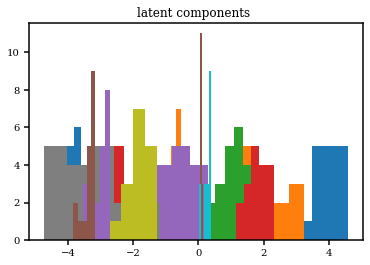

(18, 16)


In [6]:
for i in range(16):
    plt.hist(ss[:,i],bins=5,label='l'+str(i+1))
plt.title('latent components ')
plt.show()

print(np.shape(ss))

In [7]:
file="./saved_models/my_posterior_m14_z15.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

posteriors=[]


for i in trange(18):
    posteriors.append(np.array(qphi.sample((1000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)

100%|██████████| 18/18 [00:32<00:00,  1.81s/it]


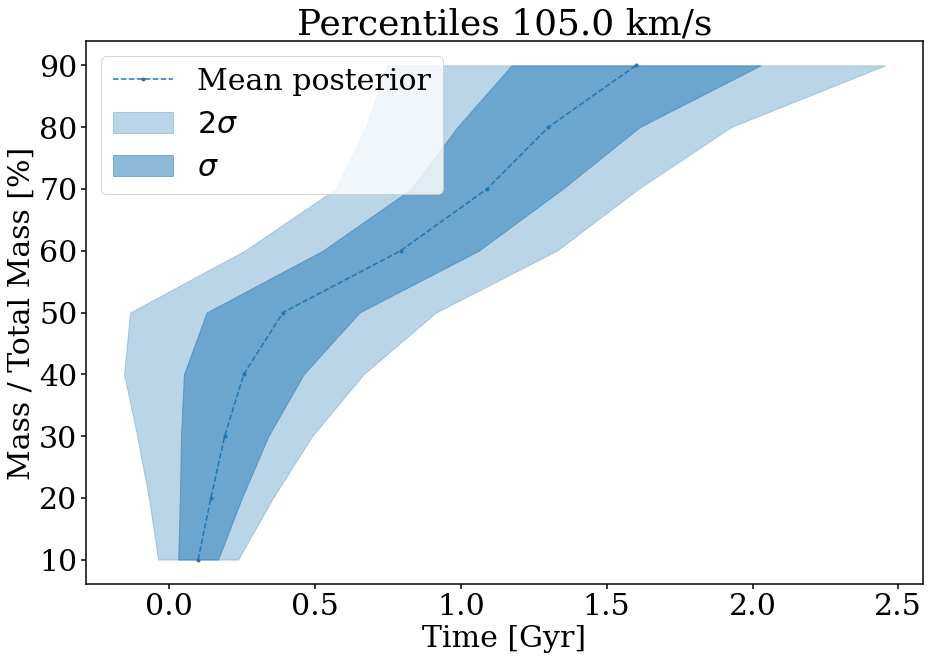

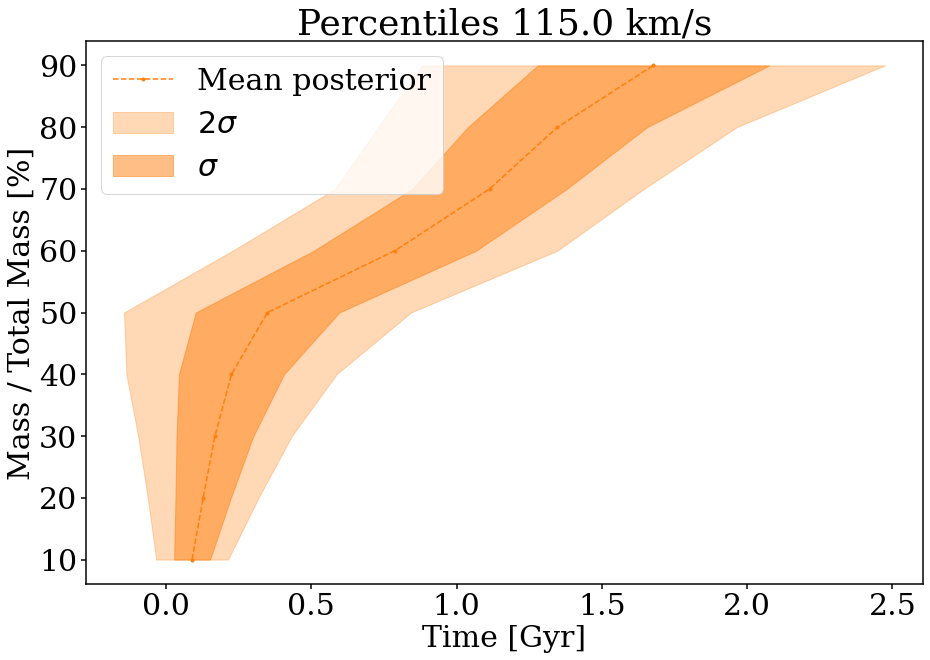

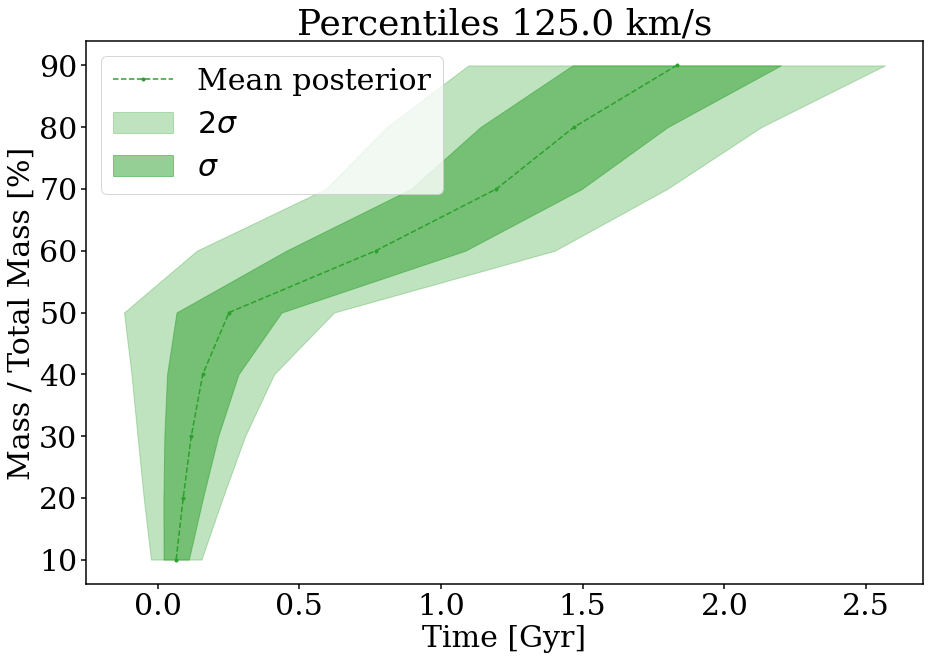

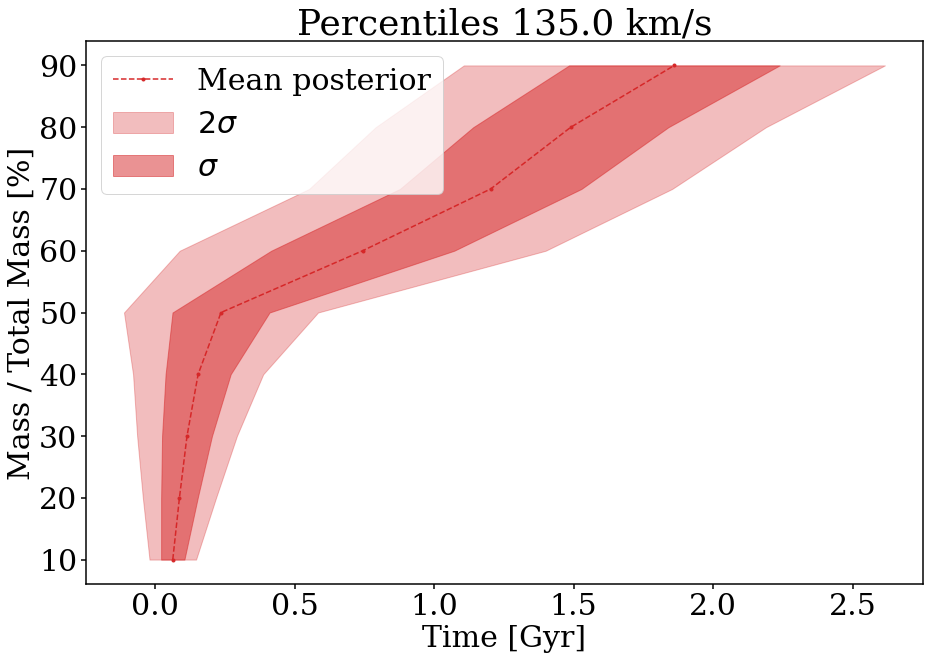

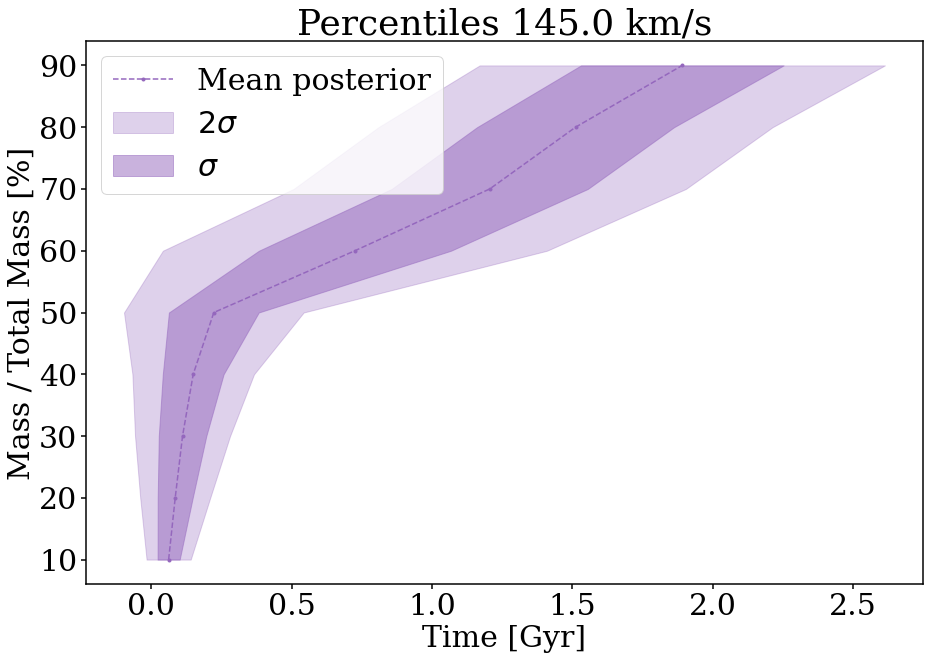

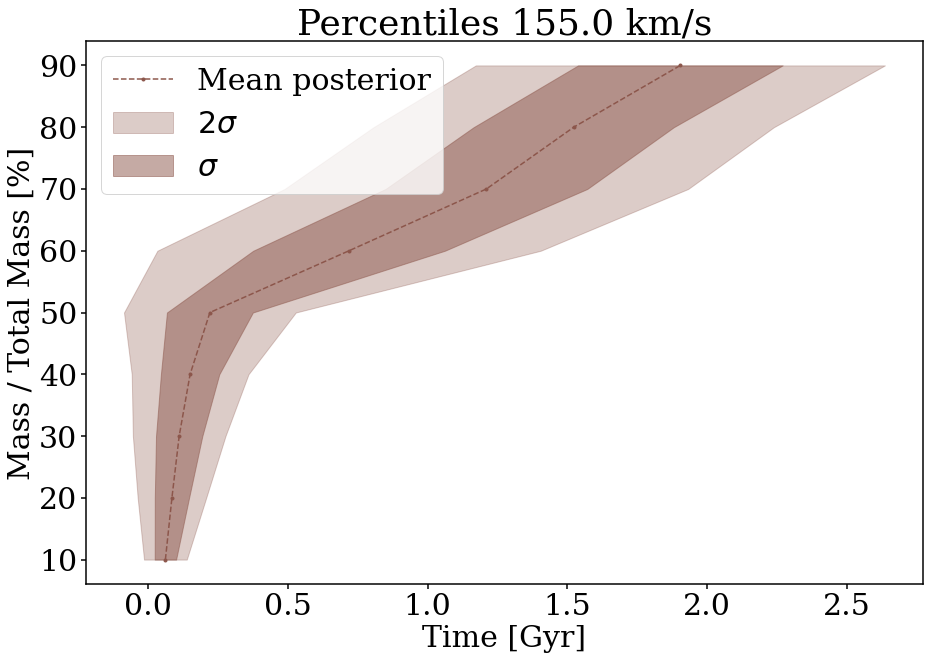

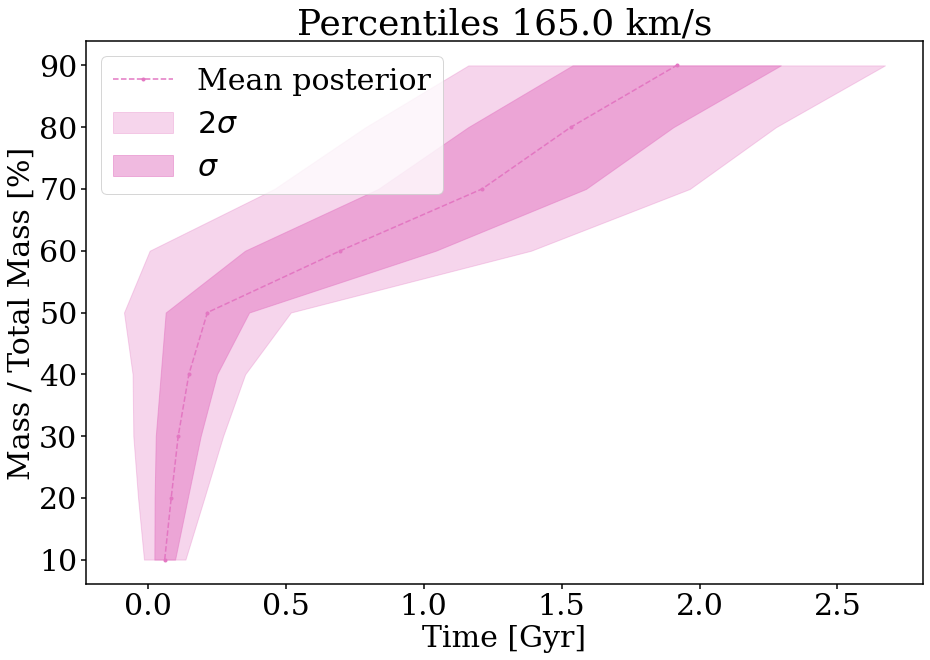

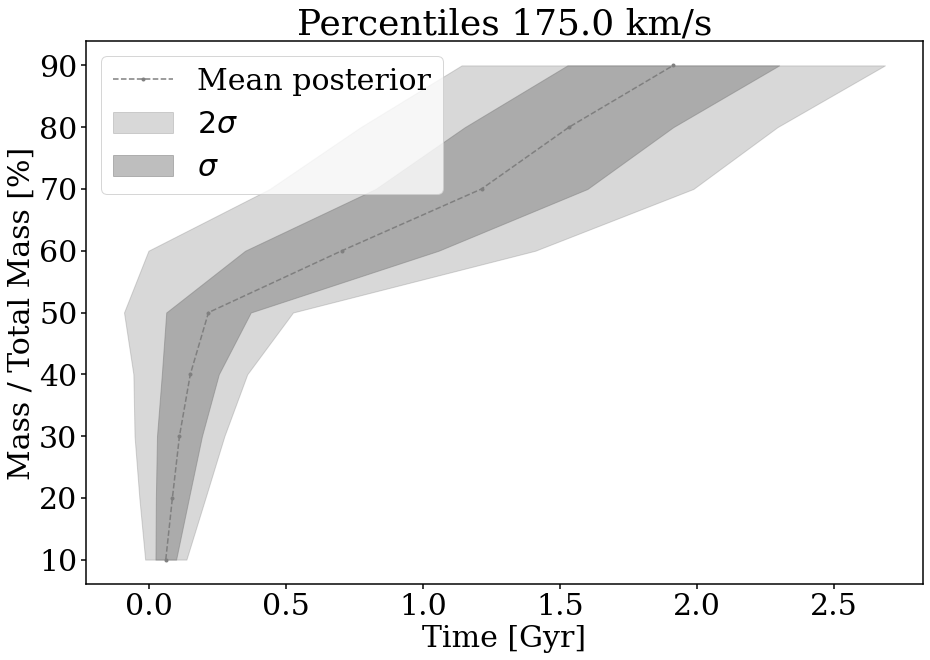

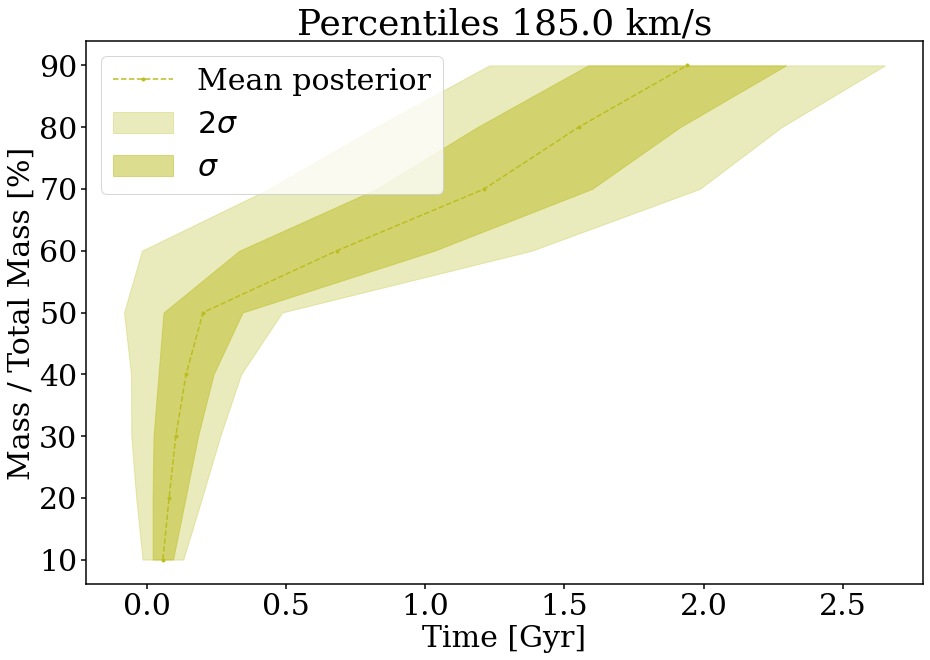

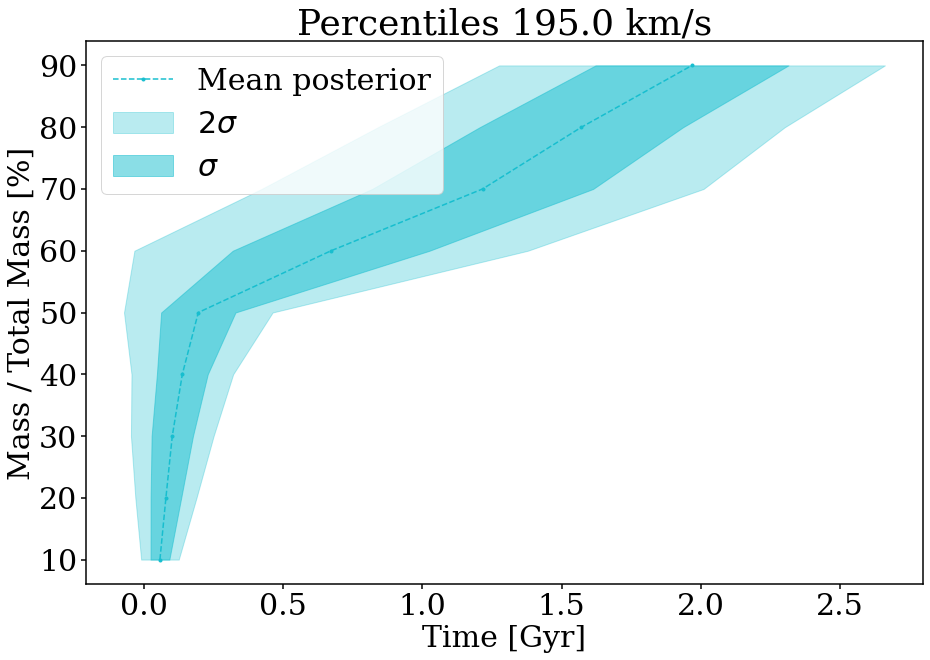

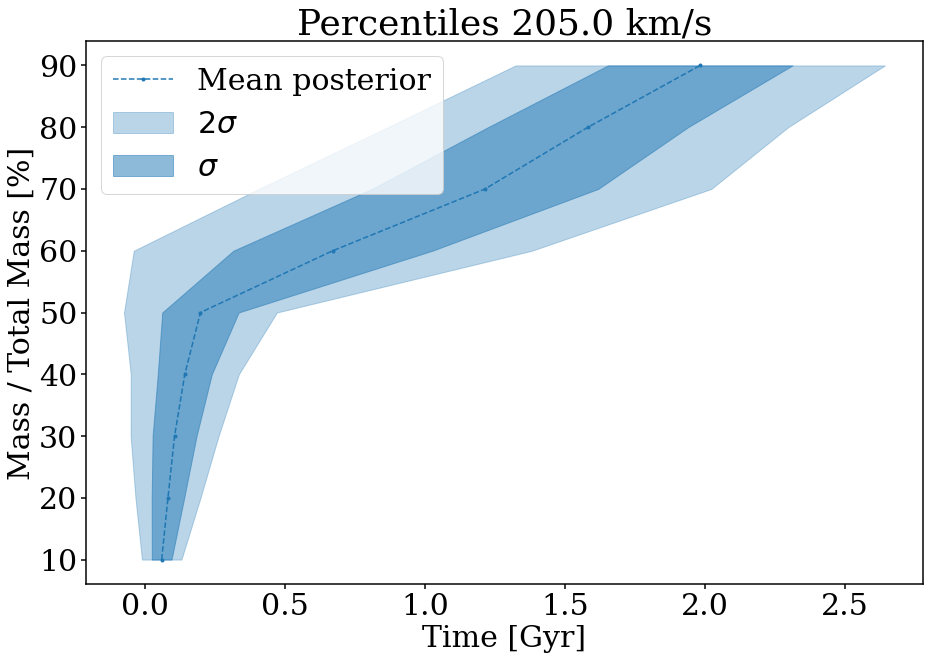

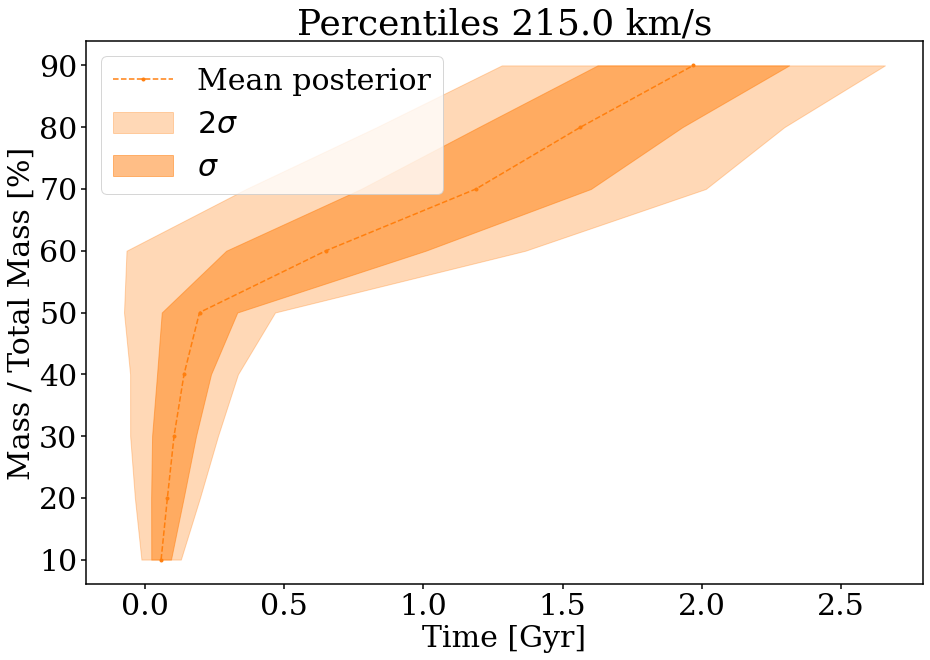

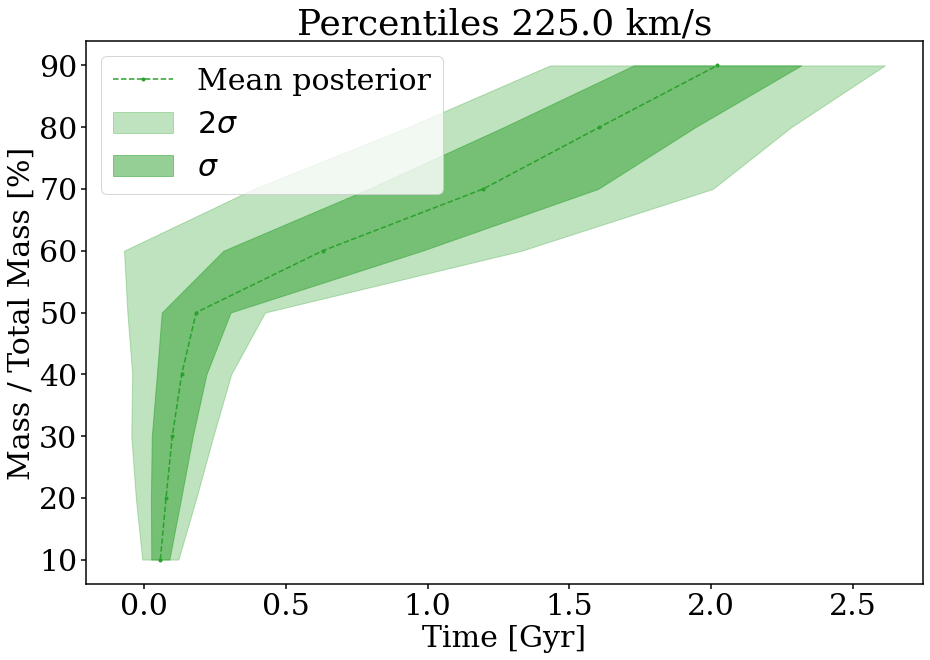

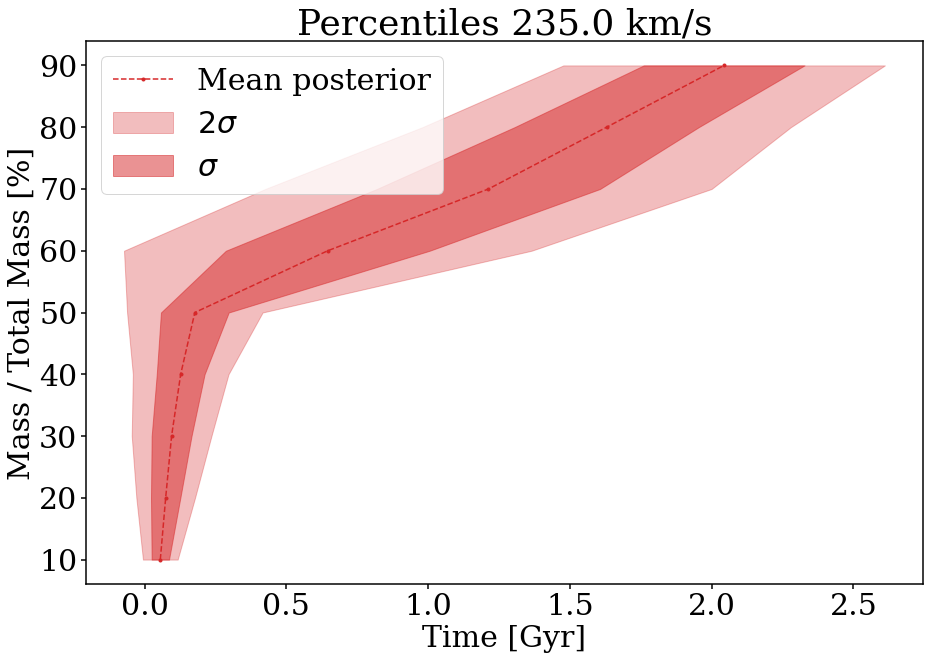

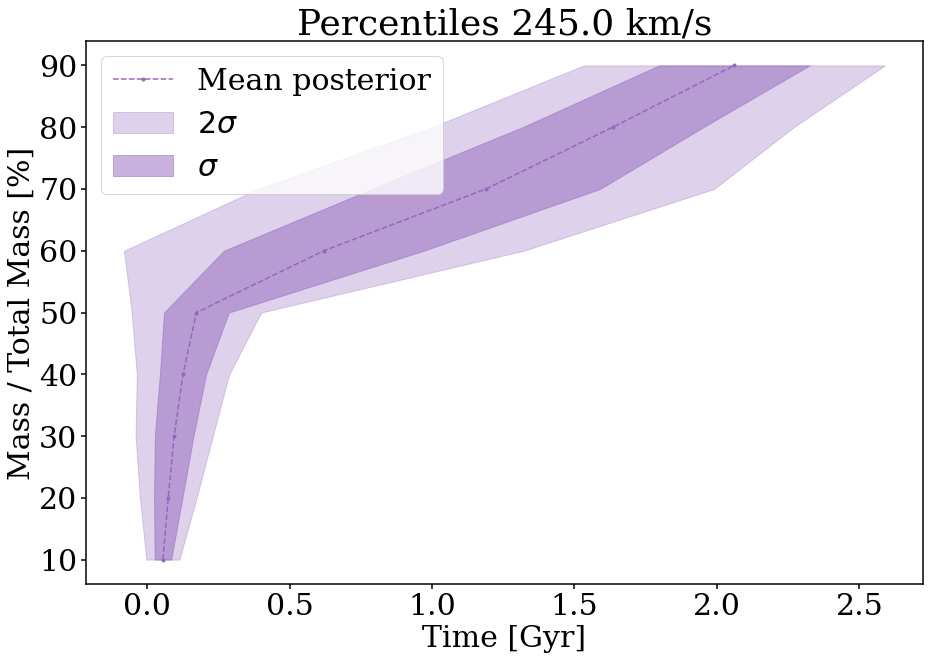

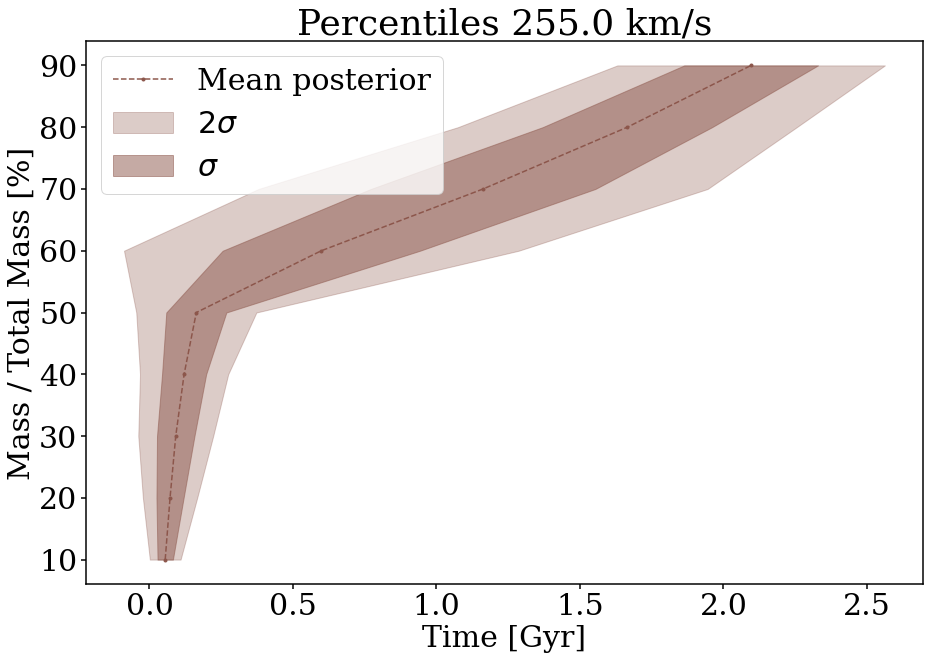

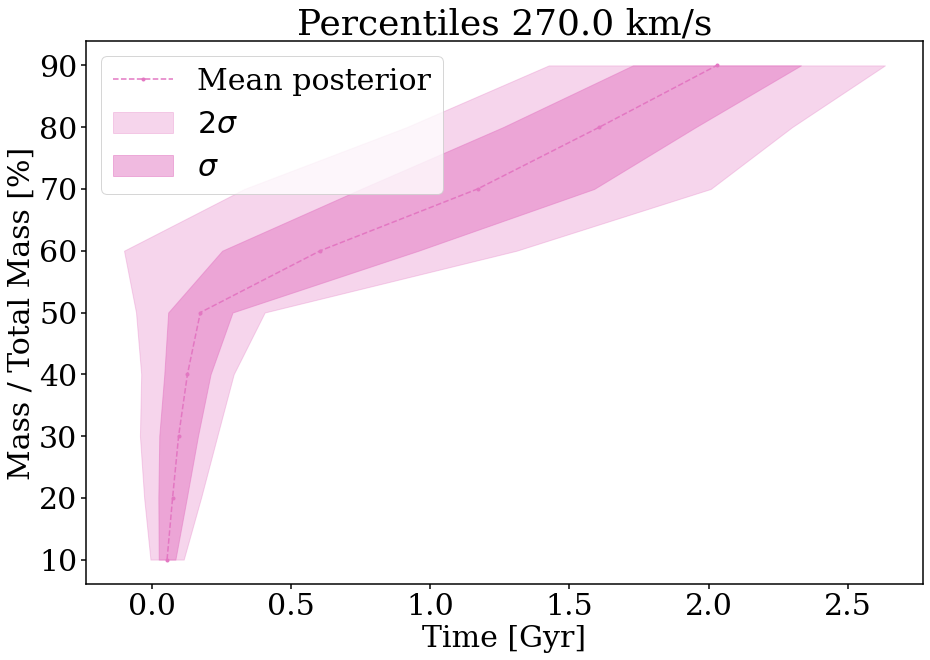

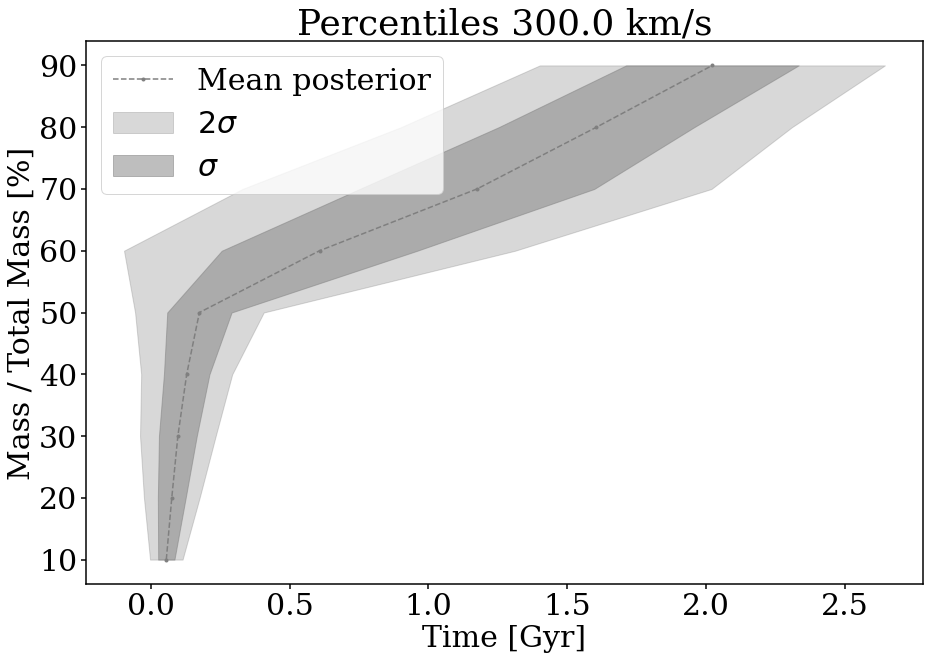

In [31]:
def plot_percentile_distribution(index_list=range(18),avoid_80=False):
    
    if avoid_80:

        for k,j in enumerate(index_list):
                
                Xobs=ss[j,:]
                posterior_samples= np.array(qphi.sample((5000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))
                
                mask=np.arange(10,100,10)!=80

                
                plt.plot(np.mean(posterior_samples,axis=0)[:9][mask],np.arange(10,100,10)[mask],'.--',color='C'+str(k),label='predicted index '+str(j))
                
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+2*np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-2*np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.3,label='$2\\sigma$')
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.5,label='$\\sigma$')
                plt.title('Percentiles '+str(sigma_gal[k])+' km/s')
                plt.legend()
                plt.xlabel('Time [Gyr]')
                plt.ylabel('Mass / Total Mass [%]')
                        #plt.savefig('prediction_1e5_m216_'+str(k)+'.jpg')
                plt.show()

    else:

        for k,j in enumerate(index_list):
                
            Xobs=ss[j,:]
            posterior_samples= np.array(qphi.sample((5000,), 
                                                x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                    show_progress_bars=False).detach().to('cpu'))
            
            
            plt.plot(np.mean(posterior_samples,axis=0)[:9],np.arange(10,100,10),'.--',color='C'+str(k),label='Mean posterior')
            plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+2*np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-2*np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.3,label='$2\\sigma$')
            plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)[:9]+np.std(posterior_samples[:,:9],axis=0),np.mean(posterior_samples,axis=0)[:9]-np.std(posterior_samples[:,:9],axis=0),color='C'+str(k),alpha=0.5,label='$\\sigma$')
            plt.title('Percentiles '+str(sigma_gal[k])+' km/s')
            plt.legend()
            plt.xlabel('Time [Gyr]')
            plt.ylabel('Mass / Total Mass [%]')
                    #plt.savefig('prediction_1e5_m216_'+str(k)+'.jpg')
            plt.show()

       


    

plot_percentile_distribution()

In [6]:
import numpy as np
mask=np.arange(10,100,10)!=80

print(mask)

[ True  True  True  True  True  True  True False  True]


In [15]:
print(sigma_gal)

[105.0, 115.0, 125.0, 135.0, 145.0, 155.0, 165.0, 175.0, 185.0, 195.0, 205.0, 215.0, 225.0, 235.0, 245.0, 255.0, 270.0, 300.0]


In [15]:
print(np.shape(posteriors))

means=np.mean(posteriors,axis=1)
print(np.shape(means))



(18, 1000, 10)
(18, 10)


In [16]:
delta_t=0.01348046441147335
ms_from_percentiles=[]
for i in trange(18):
    per=means[i,:9]
    ms=np.gradient(np.arange(0.1,1,0.1),per) #unit Msun/gyr
    ms_from_percentiles.append(ms*delta_t) #unit Msun
ms_from_percentiles=np.array(ms_from_percentiles)

100%|██████████| 18/18 [00:00<00:00, 5044.60it/s]


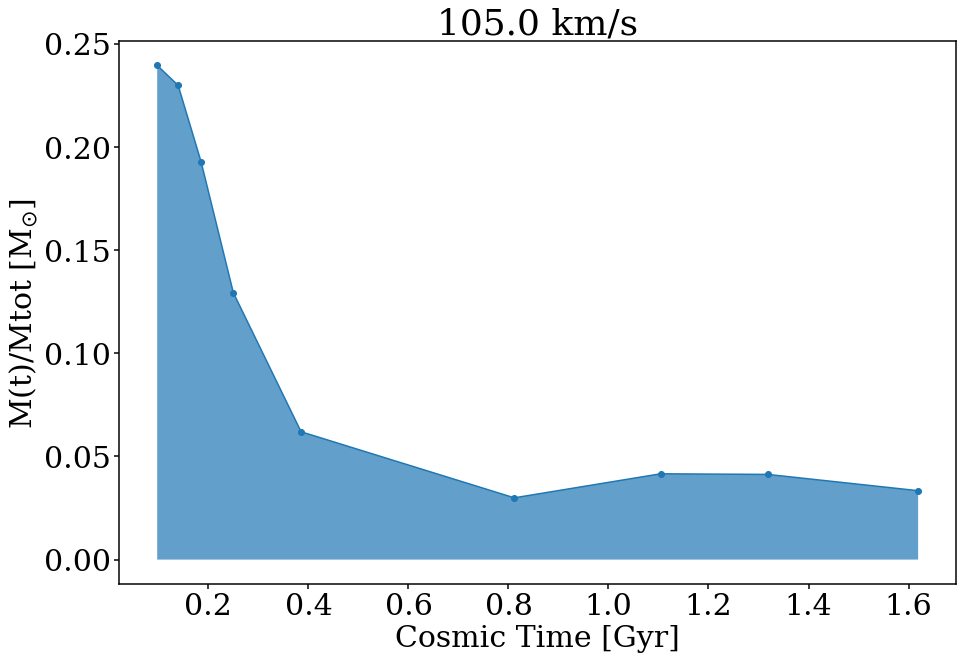

1.0


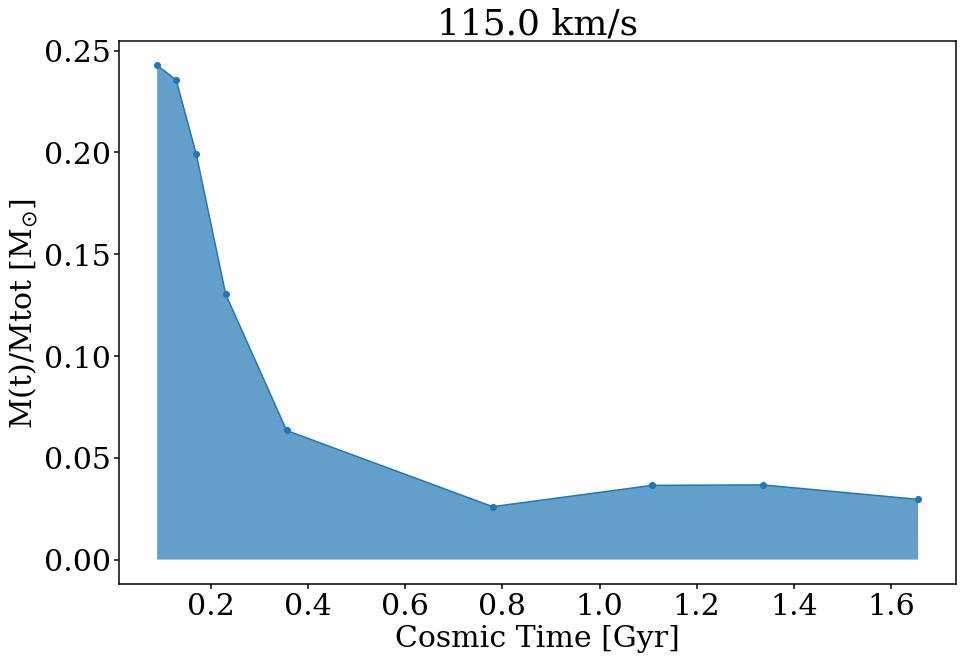

0.9999999999999999


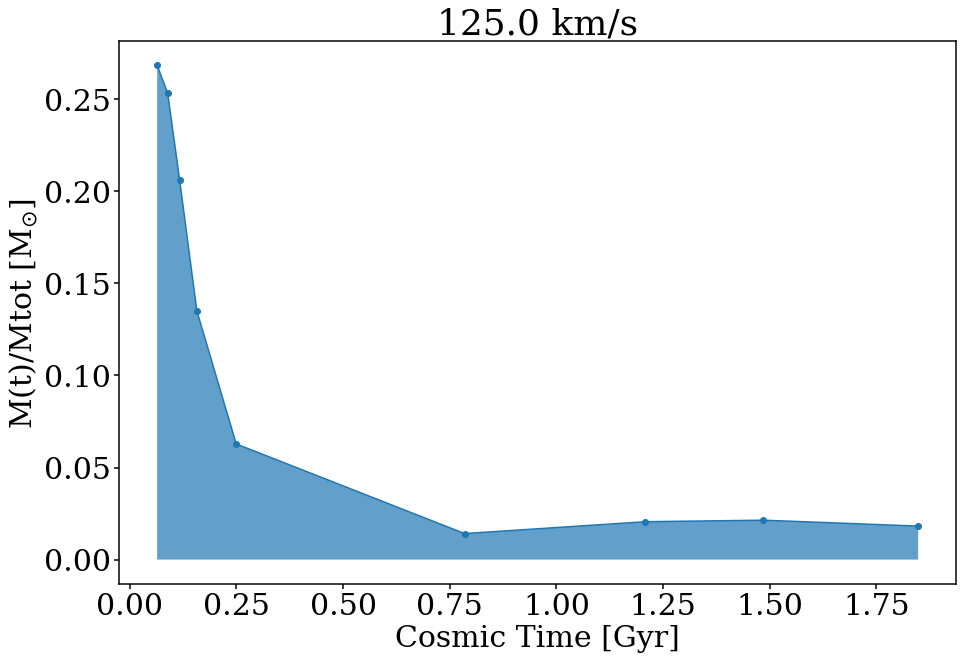

1.0


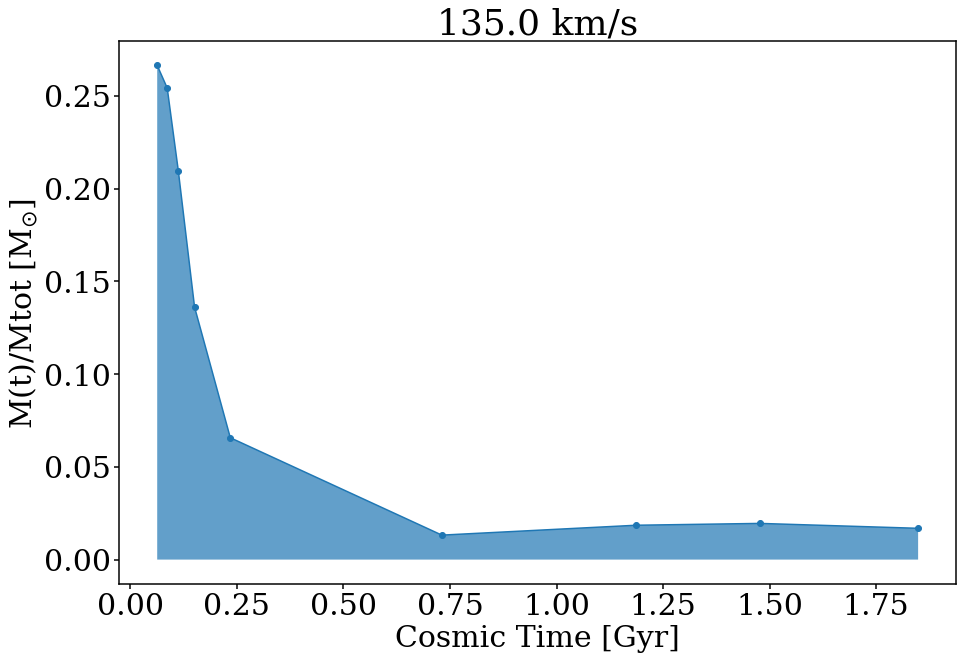

1.0


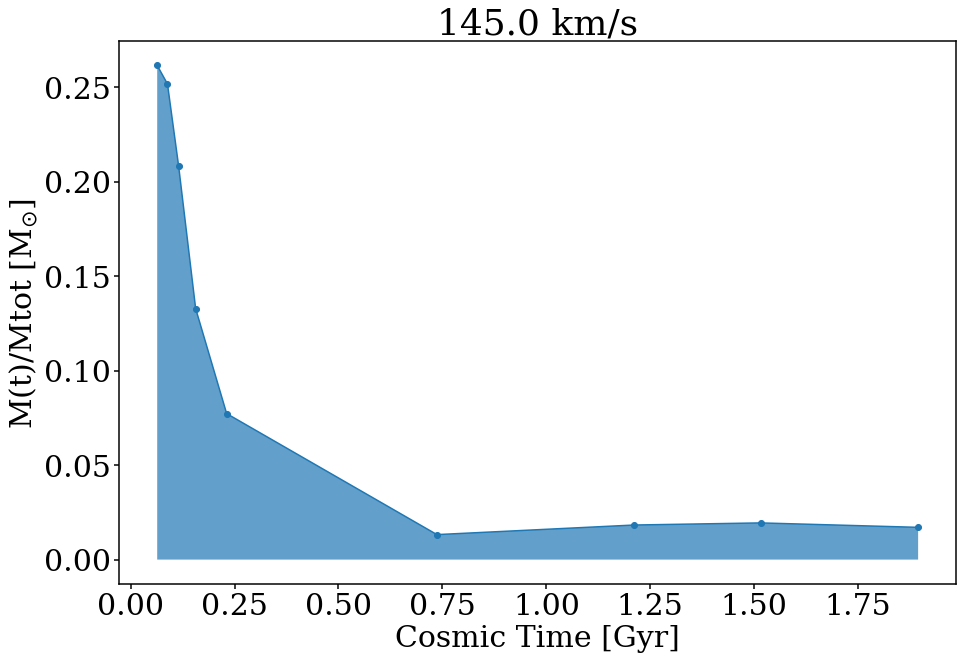

0.9999999999999999


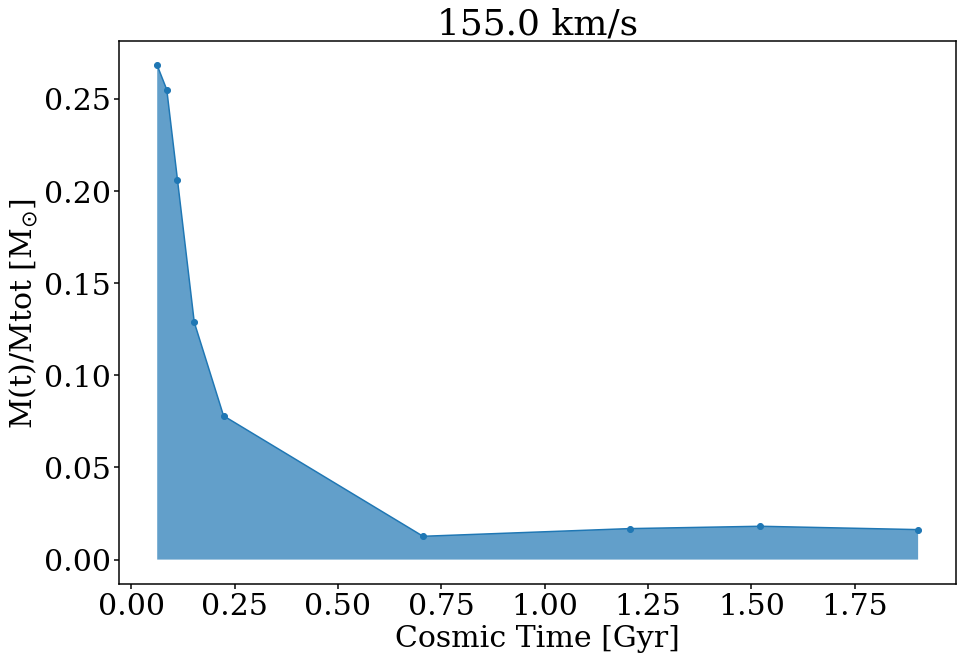

0.9999999999999999


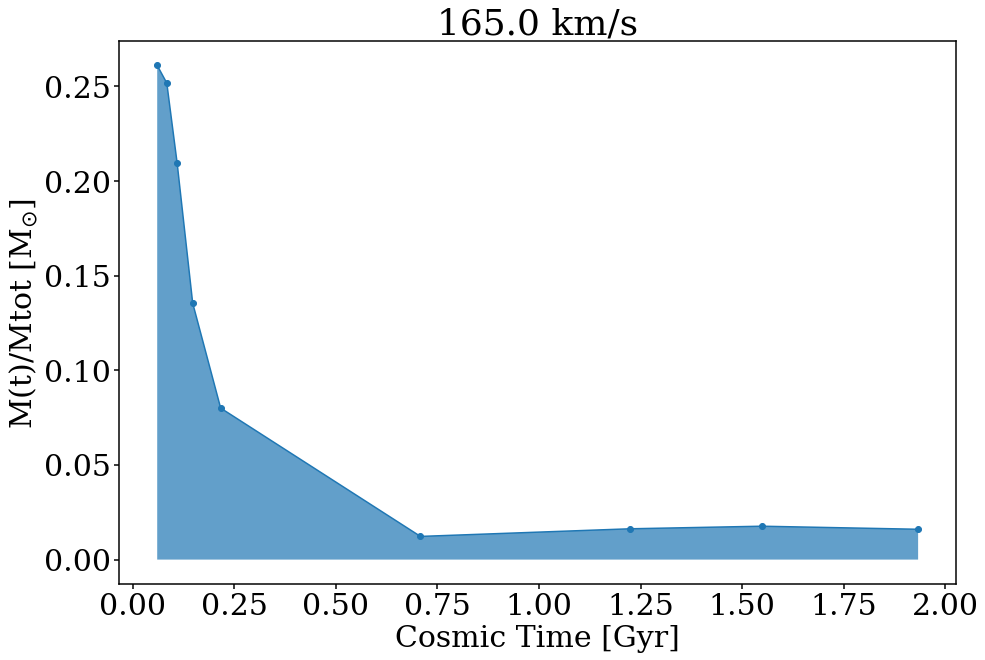

1.0


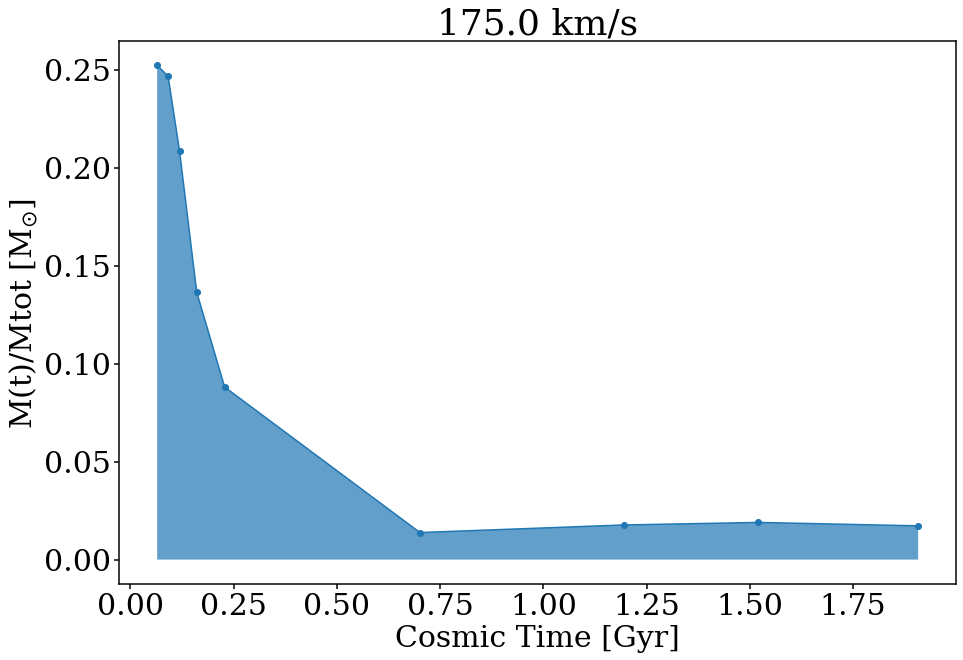

1.0


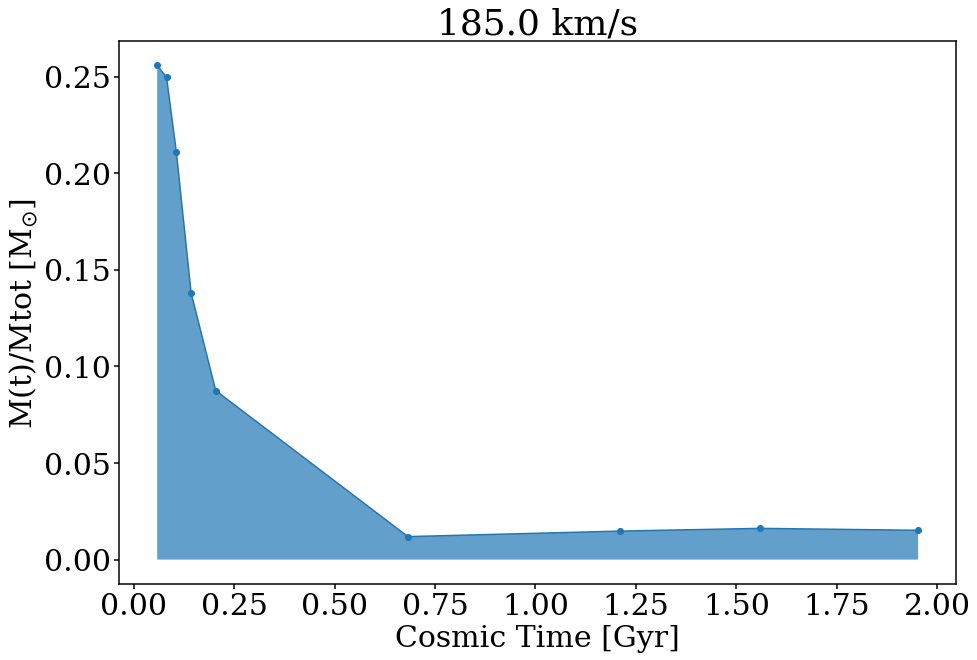

1.0


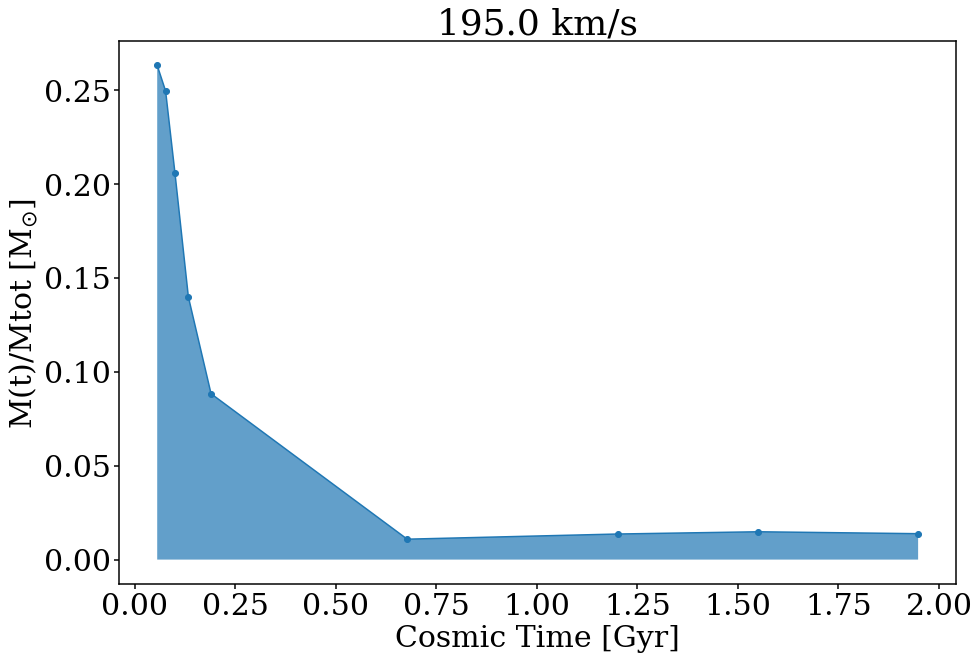

0.9999999999999999


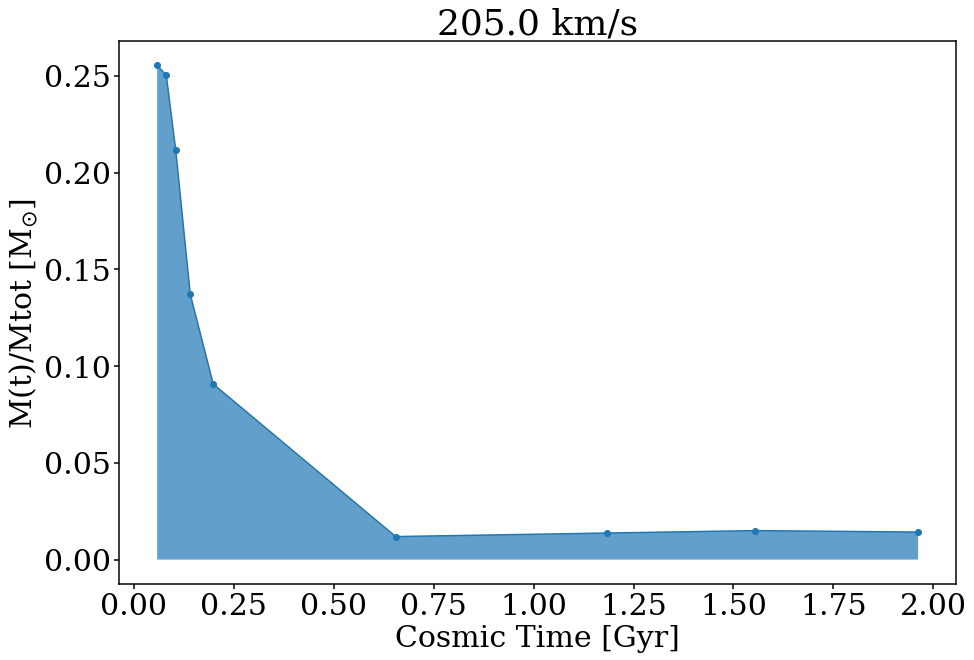

1.0000000000000002


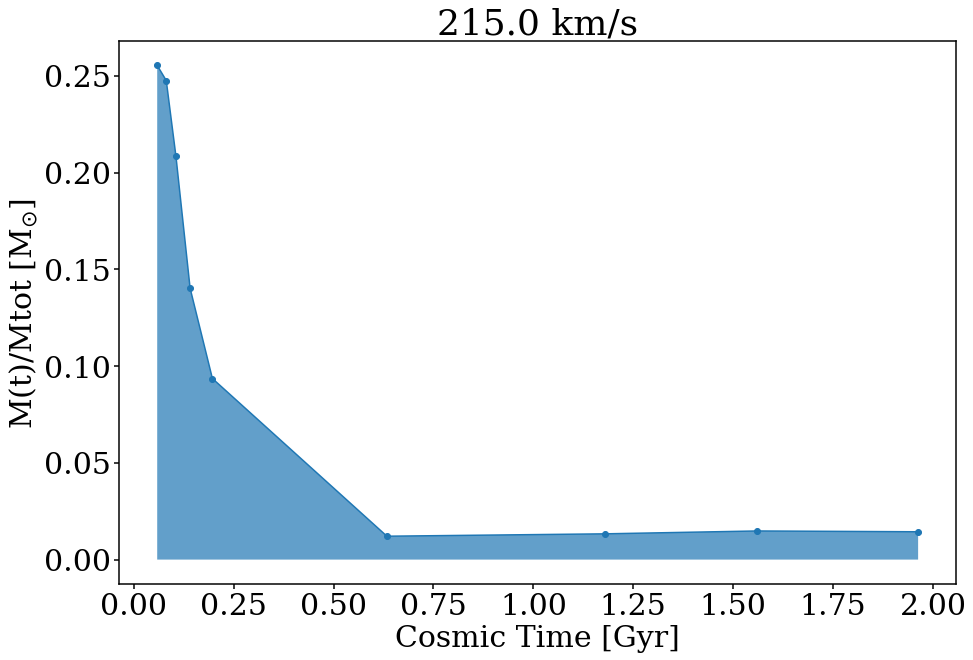

1.0000000000000002


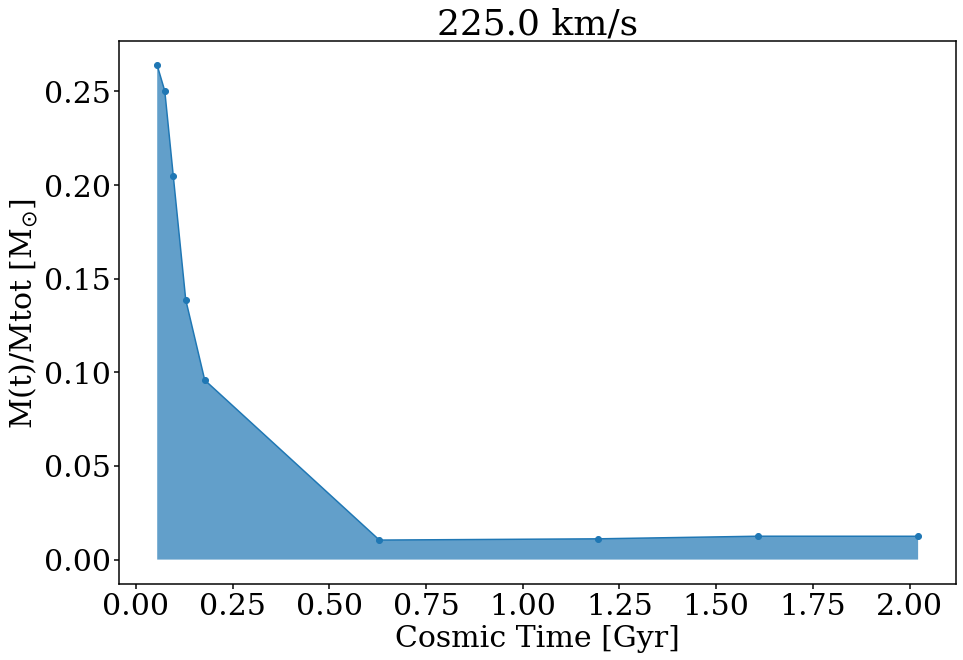

1.0


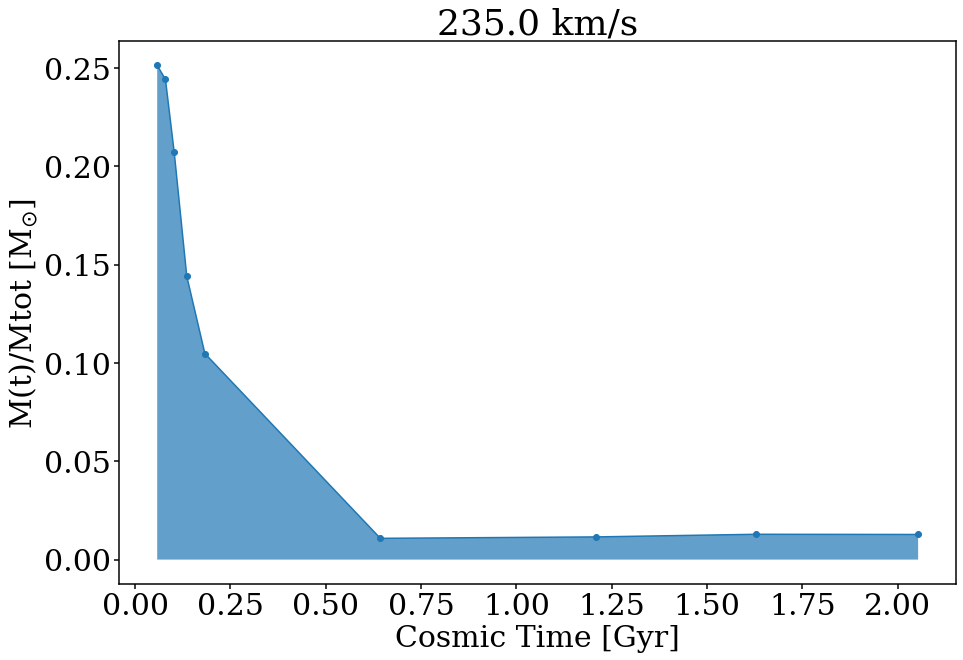

1.0


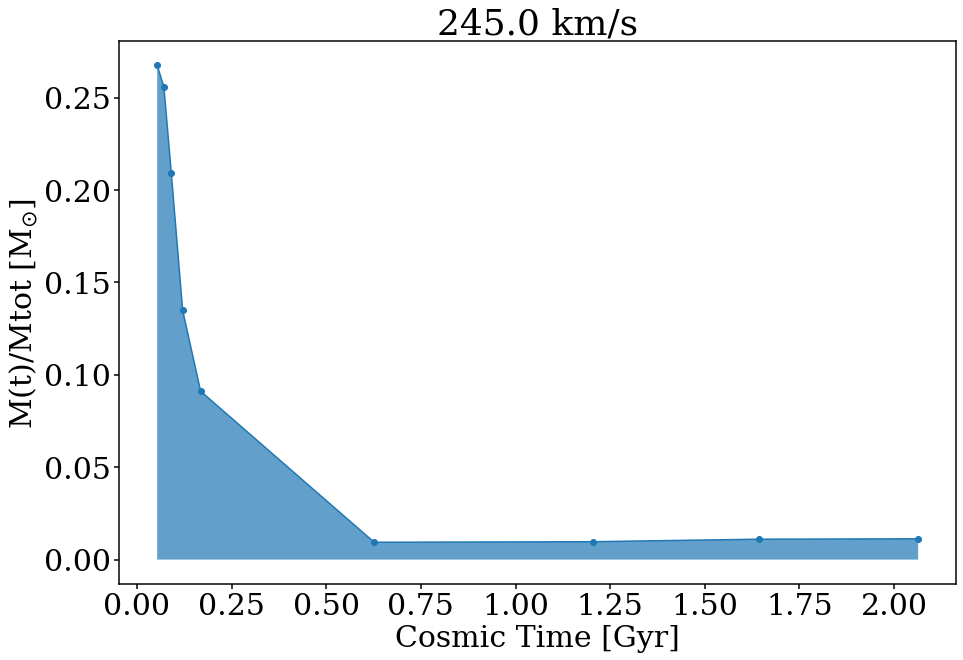

1.0000000000000002


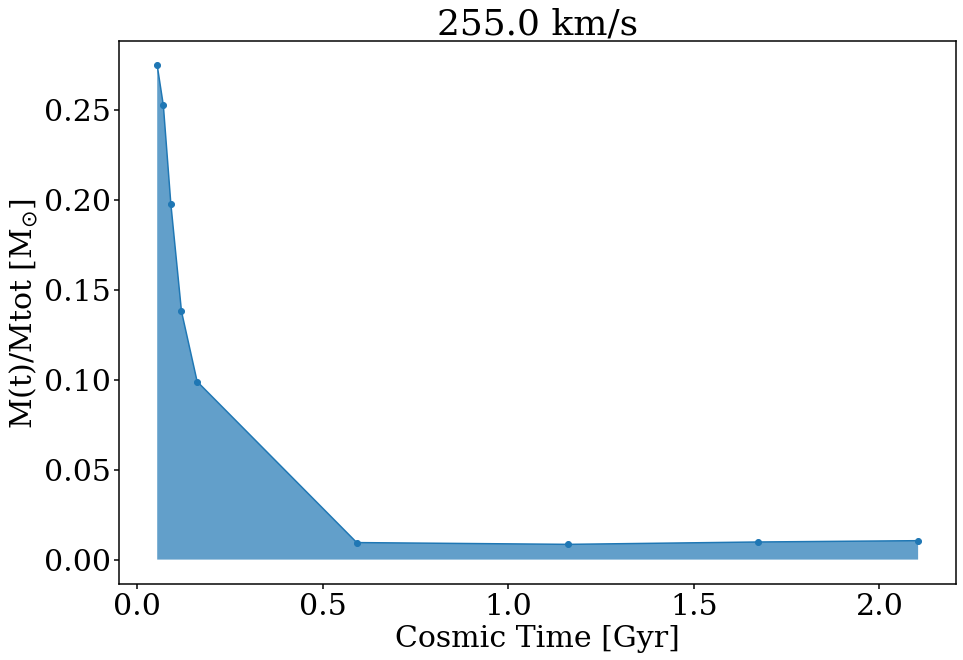

1.0000000000000002


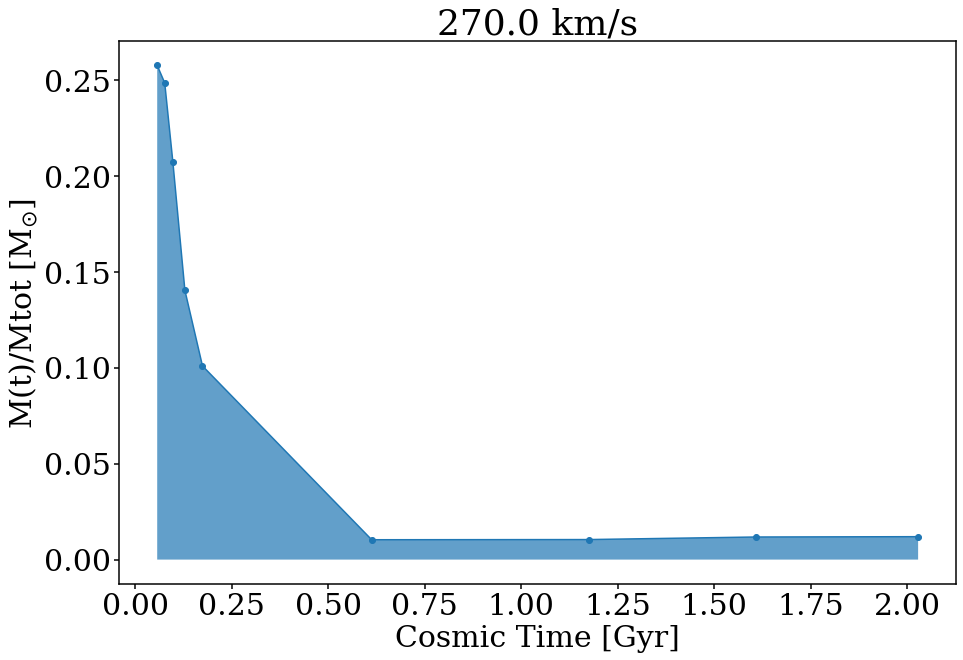

1.0


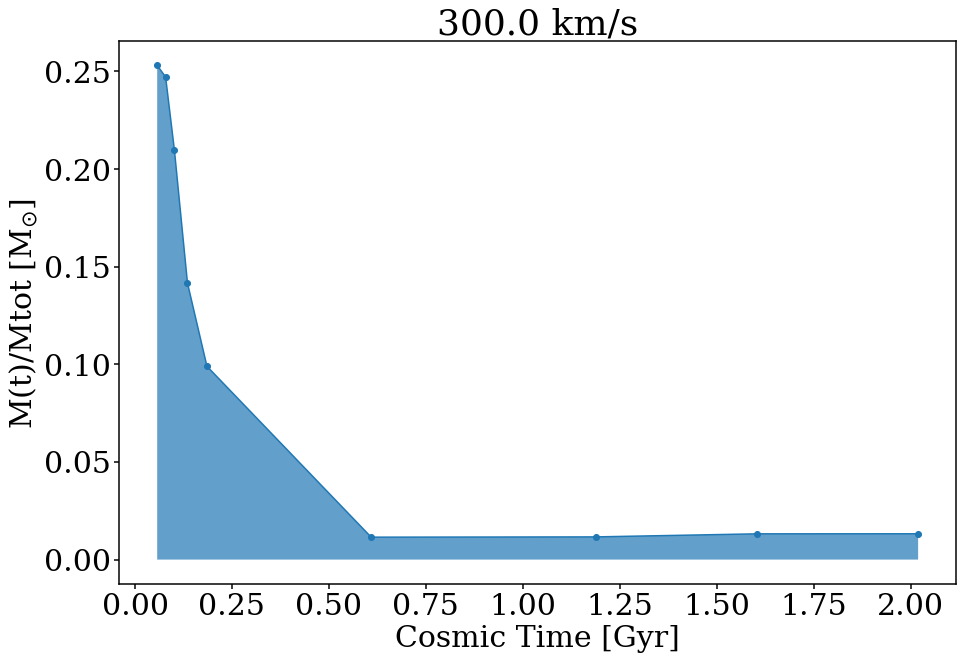

1.0


In [32]:
for i in range(18):
    ms=ms_from_percentiles[i]
    per=means[i,:9]
    plt.plot(per,ms*delta_t/np.sum
    (ms*delta_t),'o-',color='tab:blue')
    plt.fill_between(per, 0,ms*delta_t/np.sum
    (ms*delta_t),alpha=0.7) 
    plt.xlabel('Cosmic Time [Gyr]')
    plt.ylabel('M(t)/Mtot [M$_{\\odot}$]')
    plt.title(str(sigma_gal[i])+' km/s')
    plt.show()
    print(np.sum(ms*delta_t/np.sum
    (ms*delta_t)))


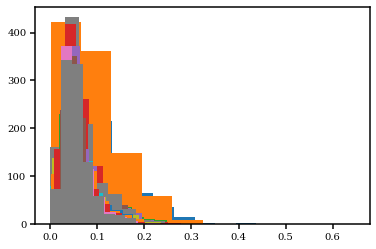

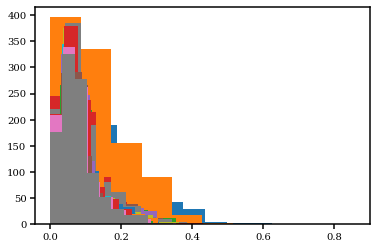

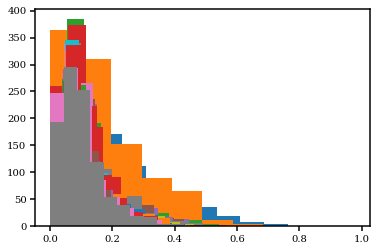

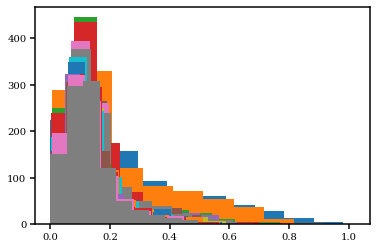

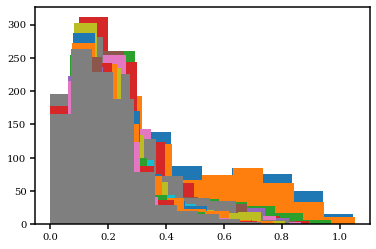

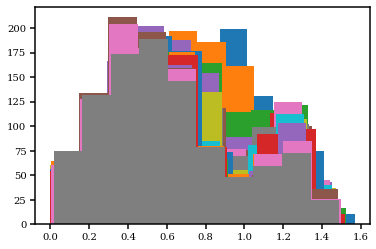

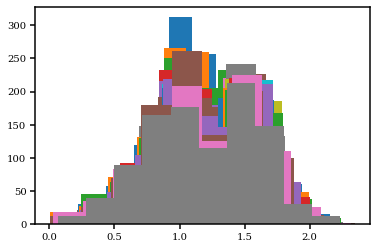

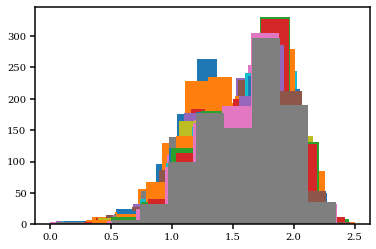

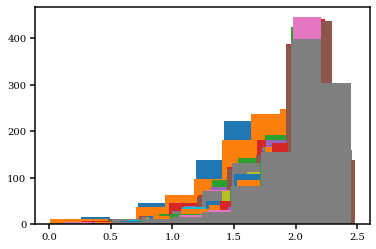

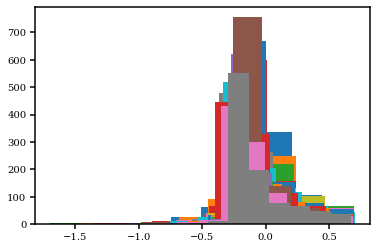

In [18]:
for i in range(10):
    for j in range(18):
        plt.hist(posteriors[j,:,i])
    plt.show()

In [33]:
print(means[:,-1]) #less massive, less metallic

[-0.0332091  -0.02488054 -0.01180259 -0.04821561 -0.047572   -0.06008986
 -0.05996758 -0.06425111 -0.05120092 -0.05893675 -0.05025613 -0.06307369
 -0.06276287 -0.07170642 -0.08614763 -0.09883703 -0.07499862 -0.05760182]
